# Hyperparameter Tuning using HyperDrive

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [1]:
import os
import shutil
import urllib
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import argparse
import joblib
import pandas as pd

import azureml.core
from azureml.core import Workspace, Environment, Experiment, Datastore, Dataset, ScriptRunConfig
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.runconfig import RunConfiguration
from azureml.exceptions import ComputeTargetException
from azureml.pipeline.steps import HyperDriveStep, HyperDriveStepRun, PythonScriptStep
from azureml.pipeline.core import Pipeline, PipelineData, TrainingOutput
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)
print("SKlearn version",sklearn.__version__)

SDK version: 1.57.0
SKlearn version 1.5.1


## Dataset

TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [2]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

quick-starts-ws-268633
aml-quickstarts-268633
southcentralus
610d6e37-4747-4a20-80eb-3aad70a55f43


In [3]:
experiment_name = 'CapstoneExp-Hyper'
project_folder = './Capstone-project'

experiment=Experiment(ws, experiment_name)
experiment

Name,Workspace,Report Page,Docs Page
CapstoneExp-Hyper,quick-starts-ws-268633,Link to Azure Machine Learning studio,Link to Documentation


In [4]:
found = False
key = "divorce-datasets"
description_text = "Split or Stay: Divorce Predictor Dataset - from kaggle"

if key in ws.datasets.keys(): 
        found = True
        dataset = ws.datasets[key] 
    
if not found:
        # Create AML Dataset and register it into Workspace
        example_data = 'https://raw.githubusercontent.com/duclinh/Capstone-Azure-Machine-Learning/refs/heads/main/Datasets/Divorce-Predictor-Dataset.csv'
        dataset = Dataset.Tabular.from_delimited_files(example_data)        
        #Register Dataset in Workspace
        dataset = dataset.register(workspace=ws,
                                   name=key,
                                   description=description_text)

df = dataset.to_pandas_dataframe()
df.describe() 

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}


,Atr1,Atr2,Atr3,Atr4,Atr5,Atr6,Atr7,Atr8,Atr9,Atr10,...,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54,Class
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,1.776471,1.652941,1.764706,1.482353,1.541176,0.747059,0.494118,1.452941,1.458824,1.576471,...,2.552941,2.270588,2.741176,2.382353,2.429412,2.476471,2.517647,2.241176,2.011765,0.494118
std,1.627257,1.468654,1.415444,1.504327,1.632169,0.904046,0.898698,1.546371,1.557976,1.421529,...,1.371786,1.586841,1.137348,1.511587,1.405090,1.260238,1.476537,1.505634,1.667611,0.501442
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,...,3.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,2.000000,0.000000
75%,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000


In [5]:
# Here we can see the general statistics about our variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Atr1,170.0,1.776471,1.627257,0.0,0.0,2.0,3.0,4.0
Atr2,170.0,1.652941,1.468654,0.0,0.0,2.0,3.0,4.0
Atr3,170.0,1.764706,1.415444,0.0,0.0,2.0,3.0,4.0
Atr4,170.0,1.482353,1.504327,0.0,0.0,1.0,3.0,4.0
Atr5,170.0,1.541176,1.632169,0.0,0.0,1.0,3.0,4.0
Atr6,170.0,0.747059,0.904046,0.0,0.0,0.0,1.0,4.0
Atr7,170.0,0.494118,0.898698,0.0,0.0,0.0,1.0,4.0
Atr8,170.0,1.452941,1.546371,0.0,0.0,1.0,3.0,4.0
Atr9,170.0,1.458824,1.557976,0.0,0.0,1.0,3.0,4.0
Atr10,170.0,1.576471,1.421529,0.0,0.0,2.0,3.0,4.0


/tmp/ipykernel_20570/40091660.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Class', palette=palette, ax=axes[0])


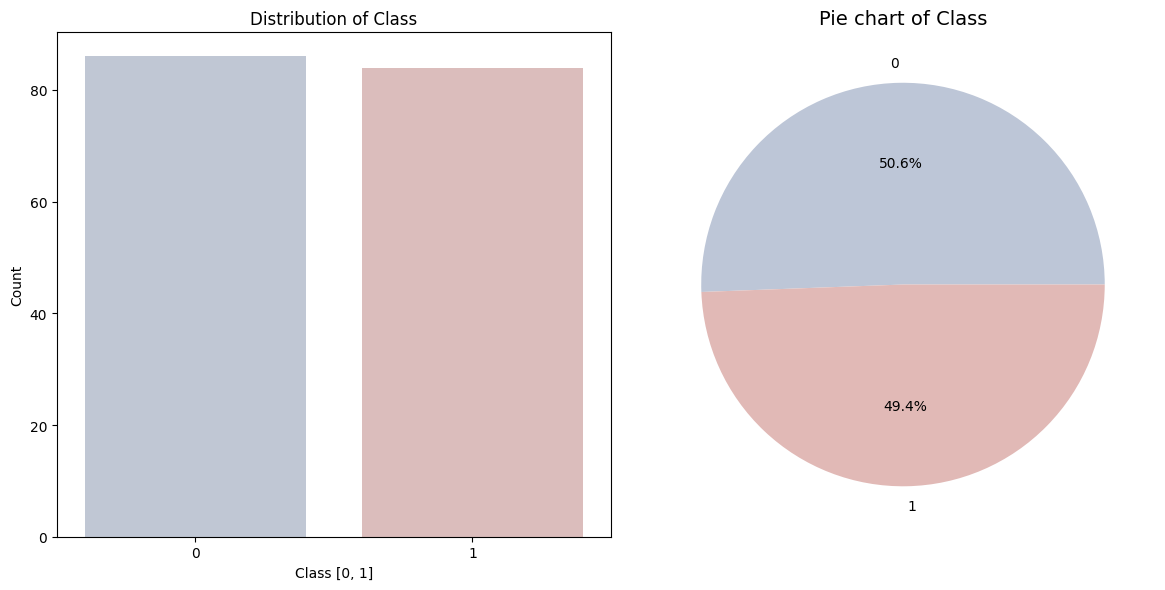

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
palette = sns.color_palette('vlag',2)

sns.countplot(data=df, x='Class', palette=palette, ax=axes[0])
axes[0].set_title('Distribution of Class')
axes[0].set_xlabel('Class [0, 1]')
axes[0].set_ylabel('Count')

df['Class'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[1], colors=palette)
axes[1].set_title('Pie chart of Class', fontsize=14)
axes[1].set_ylabel('')

plt.tight_layout()

In [7]:
amlcompute_cluster_name = "capstone-cluter"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_DS3_v2',
                                                           max_nodes=5)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True, min_node_count = 1, timeout_in_minutes = 10)

Found existing cluster, use it.
Succeeded.................................................................................................................
AmlCompute wait for completion finished

Wait timeout has been reached
Current provisioning state of AmlCompute is "Succeeded" and current node count is "0"


In [8]:
%%writefile train.py


import argparse
import os
import numpy as np
import joblib

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from azureml.core.run import Run
from azureml.data.dataset_factory import TabularDatasetFactory
from argparse import ArgumentParser
from azureml.core import Workspace, Dataset

subscription_id = '610d6e37-4747-4a20-80eb-3aad70a55f43'
resource_group = 'aml-quickstarts-268633'
workspace_name = 'quick-starts-ws-268633'

workspace = Workspace(subscription_id, resource_group, workspace_name)
dataset = Dataset.get_by_name(workspace, name='divorce-datasets')
# dataset.to_pandas_dataframe()

run = Run.get_context()
x_df = dataset.to_pandas_dataframe().dropna()
y_df = x_df.pop("Class")
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=0)

def main():
    # Add arguments to script
    parser = argparse.ArgumentParser()

    parser.add_argument('--C', type=float, default=1.0, help="Inverse of regularization strength. Smaller values cause stronger regularization")
    parser.add_argument('--max_iter', type=int, default=100, help="Maximum number of iterations to converge")
    parser.add_argument('--solver', type=str, default='lbfgs', help="chose the algorithm to train the model")

    args = parser.parse_args()

    run.log("Regularization Strength:", np.float(args.C))
    run.log("Max iterations:", np.int(args.max_iter))
    run.log("Algorithm: ", args.solver)

    # creates the logistic regression model
    model = LogisticRegression(solver=args.solver, C=args.C, max_iter=args.max_iter).fit(x_train, y_train)

    # gets and logs the accuracy
    accuracy = model.score(x_test, y_test)
    run.log("Accuracy", np.float(accuracy))
    
    # dumps the run
    os.makedirs('outputs', exist_ok=True)
    joblib.dump(model,'outputs/model.joblib')

if __name__ == '__main__':
    main()

Overwriting train.py


## Hyperdrive Configuration

TODO: Explain the model you are using and the reason for chosing the different hyperparameters, termination policy and config settings.

In [8]:
from azureml.train.hyperdrive import uniform

# TODO: Create an early termination policy. This is not required if you are using Bayesian sampling.
early_termination_policy = BanditPolicy(evaluation_interval=2, slack_factor=0.2)

# Specify parameter sampler
sample_space = {
    'C': choice(0.01, 0.1, 1, 10, 100),
    'max_iter' : choice(50,75,100,125,150,175,200),
    'solver' : choice('liblinear','sag','lbfgs', 'saga')
}
# Specify the sampling pramater
param_sampling = RandomParameterSampling(sample_space)

if "training" not in os.listdir():
    os.mkdir("./training")
    
env = sklearn_env = Environment.from_conda_specification(name='sklearn-env', file_path='conda_dependencies.yml')

src = ScriptRunConfig(source_directory='.',
                      script='train.py',
                      compute_target=compute_target,
                      environment=env
                      )

#TODO: Create your estimator and hyperdrive config
hyperdrive_run_config = HyperDriveConfig(
                                     hyperparameter_sampling=param_sampling,
                                     primary_metric_name='Accuracy',
                                     primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                     policy=early_termination_policy,
                                     run_config=src,
                                     max_concurrent_runs=4,
                                     max_total_runs=20,                                     
                                    )

In [9]:
#TODO: Submit your experiment
hyperDrive_run = experiment.submit(hyperdrive_run_config,  show_output= True)

## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [10]:
from azureml.widgets import RunDetails
RunDetails(hyperDrive_run).show()
for children_run in hyperDrive_run.get_children():
    print('------')
    print(children_run)

2024-10-13 20:25:50.212050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 20:25:50.234241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 20:25:50.240799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 20:25:50.256972: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 20:25:51.366475: W tensorflow/comp

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

------
Run(Experiment: CapstoneExp-Hyper,
Id: HD_c40f10a5-a95b-4463-968a-1067c18f25a1_2,
Type: azureml.scriptrun,
Status: Queued)
------
Run(Experiment: CapstoneExp-Hyper,
Id: HD_c40f10a5-a95b-4463-968a-1067c18f25a1_3,
Type: azureml.scriptrun,
Status: Queued)
------
Run(Experiment: CapstoneExp-Hyper,
Id: HD_c40f10a5-a95b-4463-968a-1067c18f25a1_1,
Type: azureml.scriptrun,
Status: Queued)
------
Run(Experiment: CapstoneExp-Hyper,
Id: HD_c40f10a5-a95b-4463-968a-1067c18f25a1_0,
Type: azureml.scriptrun,
Status: Queued)


In [11]:
hyperDrive_run.wait_for_completion(show_output=True)

RunId: HD_c40f10a5-a95b-4463-968a-1067c18f25a1
Web View: https://ml.azure.com/runs/HD_c40f10a5-a95b-4463-968a-1067c18f25a1?wsid=/subscriptions/610d6e37-4747-4a20-80eb-3aad70a55f43/resourcegroups/aml-quickstarts-268633/workspaces/quick-starts-ws-268633&tid=660b3398-b80e-49d2-bc5b-ac1dc93b5254

Streaming azureml-logs/hyperdrive.txt

[2024-10-13T20:25:43.446033][GENERATOR][INFO]Trying to sample '4' jobs from the hyperparameter space
[2024-10-13T20:25:43.9318257Z][SCHEDULER][INFO]Scheduling job, id='HD_c40f10a5-a95b-4463-968a-1067c18f25a1_0' 
[2024-10-13T20:25:44.0721002Z][SCHEDULER][INFO]Scheduling job, id='HD_c40f10a5-a95b-4463-968a-1067c18f25a1_1' 
[2024-10-13T20:25:44.1919319Z][SCHEDULER][INFO]Scheduling job, id='HD_c40f10a5-a95b-4463-968a-1067c18f25a1_2' 
[2024-10-13T20:25:44.3088960Z][SCHEDULER][INFO]Scheduling job, id='HD_c40f10a5-a95b-4463-968a-1067c18f25a1_3' 
[2024-10-13T20:25:44.263661][GENERATOR][INFO]Successfully sampled '4' jobs, they will soon be submitted to the execution t

{'runId': 'HD_c40f10a5-a95b-4463-968a-1067c18f25a1',
 'target': 'capstone-cluter',
 'status': 'Completed',
 'startTimeUtc': '2024-10-13T20:25:42.469464Z',
 'endTimeUtc': '2024-10-13T20:48:55.300895Z',
 'services': {},
 'properties': {'primary_metric_config': '{"name":"Accuracy","goal":"maximize"}',
  'resume_from': 'null',
  'runTemplate': 'HyperDrive',
  'azureml.runsource': 'hyperdrive',
  'platform': 'AML',
  'ContentSnapshotId': '43791573-3add-4a71-81d9-7bd6e2f98e11',
  'user_agent': 'python/3.10.11 (Linux-5.15.0-1073-azure-x86_64-with-glibc2.31) msrest/0.7.1 Hyperdrive.Service/1.0.0 Hyperdrive.SDK/core.1.57.0',
  'space_size': '140',
  'best_child_run_id': 'HD_c40f10a5-a95b-4463-968a-1067c18f25a1_2',
  'score': '0.9411764705882352',
  'best_metric_status': 'Succeeded',
  'best_data_container_id': 'dcid.HD_c40f10a5-a95b-4463-968a-1067c18f25a1_2'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'configuration': None,
  'attribution': None,
  'telemetryValues': {'aml

## Best Model

TODO: In the cell below, get the best model from the hyperdrive experiments and display all the properties of the model.

In [15]:
best_run = hyperDrive_run.get_best_run_by_primary_metric()
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
CapstoneExp-Hyper,HD_c40f10a5-a95b-4463-968a-1067c18f25a1_2,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [21]:
best_sample = best_run.get_details()['runDefinition']['arguments']
best_sample

['--C', '0.1', '--max_iter', '200', '--solver', 'sag']

In [22]:
best_accuracy = best_run.get_metrics(name='Accuracy')
best_accuracy

{'Accuracy': 0.9411764705882353}

In [38]:
#TODO: Save the best model
model = best_run.register_model(model_name = "hyperdrive_best_run.pkl", model_path = './outputs/')

print(best_run)
best_run.download_file( name= './outputs/hyper-model.pkl')

Run(Experiment: CapstoneExp-Hyper,
Id: HD_c40f10a5-a95b-4463-968a-1067c18f25a1_2,
Type: azureml.scriptrun,
Status: Completed)


# Model Deployment
Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [33]:
%%writefile hyper_score.py

import os
import numpy as np
import json
import joblib
from azureml.core.model import Model

def init():
    global model
    try:
        model_path = Model.get_model_path('hyperdrive_best_run.pkl')
        model = joblib.load(model_path)
    except Exception as err:
        print("init method error: "+str(err))

def run(data):
    try:
        #data = np.array(json.loads(data))
        data = json.loads(data)
        strn = "extracted json\n"
        data = np.array(data["data"])
        strn += "converted data to np array\n"
        result = model.predict(data)
        strn += "sent the data to the model for prediction\n"
        print(strn)
        return result.tolist()
    except Exception as err:
        return strn+"run method error: "+str(err)

Overwriting hyper_score.py


In [39]:
# create inference_config
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(entry_script="hyper_score.py", environment = sklearn_env)

In [40]:
deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                                    memory_gb = 1, 
                                                    auth_enabled= True, 
                                                    enable_app_insights= True)

hyper_service = Model.deploy(ws, "aciservice", [model], inference_config, deployment_config)
hyper_service.wait_for_deployment(show_output = True)

azureml.core.model:
To leverage new model deployment capabilities, AzureML recommends using CLI/SDK v2 to deploy models as online endpoint, 
please refer to respective documentations 
https://docs.microsoft.com/azure/machine-learning/how-to-deploy-managed-online-endpoints /
https://docs.microsoft.com/azure/machine-learning/how-to-attach-kubernetes-anywhere 
For more information on migration, see https://aka.ms/acimoemigration 
To disable CLI/SDK v1 deprecation warning set AZUREML_LOG_DEPRECATION_WARNING_ENABLED to 'False'


Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2024-10-13 21:31:31+00:00 Creating Container Registry if not exists.
2024-10-13 21:31:31+00:00 Registering the environment.
2024-10-13 21:31:32+00:00 Use the existing image.
2024-10-13 21:31:34+00:00 Generating deployment configuration.
2024-10-13 21:31:37+00:00 Submitting deployment to compute.
2024-10-13 21:31:42+00:00 Checking the status of deployment aciservice..
2024-10-13 21:33:18+00:00 Checking the status of inference endpoint aciservice.
Succeeded
ACI service creation operation finished, operation "Succeeded"


# Call the endpoint

In [41]:
from sklearn.model_selection import train_test_split
# get the data to send
ds = dataset.to_pandas_dataframe()
train, test = train_test_split(ds, random_state=625, shuffle=True)
tosend = test[:2].values.tolist()
tosend = [tosend[0][:-1],tosend[1][:-1]]

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}


In [44]:
url = hyper_service.scoring_uri
print(hyper_service.state)
print(hyper_service.scoring_uri)
print(hyper_service.swagger_uri)

Healthy
http://8b86d1ac-54fa-4aa7-b848-2084c8825be5.southcentralus.azurecontainer.io/score
http://8b86d1ac-54fa-4aa7-b848-2084c8825be5.southcentralus.azurecontainer.io/swagger.json


In [46]:
import requests # Used for http post request
import json

key = "gZJiWYsgIc4NfX6Q0QfGD6dPq6T5mSSB"
data = json.dumps({"data":tosend})
# Set the content type
headers = {'Content-type': 'application/json'}
headers['Authorization'] = f'Bearer {key}'

response = requests.post(url,data,headers=headers)
print(response.text)

"extracted json\nconverted data to np array\nrun method error: name 'model' is not defined"


In [48]:
hyper_service.get_logs()

'2024-10-13T21:33:07,244659300+00:00 - rsyslog/run \n2024-10-13T21:33:07,254155100+00:00 - gunicorn/run \n2024-10-13T21:33:07,258066400+00:00 | gunicorn/run | \n2024-10-13T21:33:07,262558500+00:00 | gunicorn/run | ###############################################\n2024-10-13T21:33:07,264110300+00:00 | gunicorn/run | AzureML Container Runtime Information\n2024-10-13T21:33:07,271076000+00:00 | gunicorn/run | ###############################################\n2024-10-13T21:33:07,274464700+00:00 | gunicorn/run | \n2024-10-13T21:33:07,275621700+00:00 - nginx/run \n2024-10-13T21:33:07,280348700+00:00 | gunicorn/run | \n2024-10-13T21:33:07,290085000+00:00 | gunicorn/run | AzureML image information: openmpi4.1.0-ubuntu20.04, Materializaton Build:20240709.v1\n2024-10-13T21:33:07,295375600+00:00 | gunicorn/run | \n2024-10-13T21:33:07,297018800+00:00 | gunicorn/run | \n2024-10-13T21:33:07,299494800+00:00 | gunicorn/run | PATH environment variable: /azureml-envs/azureml_7eec2c8971b9410f92147a7e257297e